Cognitive Neural Network of MRI's: Blackwell Summer Scholars Dementia Research

I will now start this jupyter notebook fresh with proper notes because I accidentally deleted all of my work from yesterday

In [1540]:

# Define the checkpoint file path
checkpoint_filepath = 'model_checkpoint.weights.h5'

# Delete the checkpoint file if it exists
if os.path.exists(checkpoint_filepath):
    os.remove(checkpoint_filepath)

# Clear any existing model
tf.keras.backend.clear_session()

In [1562]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import regularizers



In [1563]:
import shutil
import os

def merge_directories(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    for src_dir in src_dirs:
        for class_name in os.listdir(src_dir):
            class_src_path = os.path.join(src_dir, class_name)
            class_dest_path = os.path.join(dest_dir, class_name)
            
            if not os.path.exists(class_dest_path):
                os.makedirs(class_dest_path)
            
            for file_name in os.listdir(class_src_path):
                src_file_path = os.path.join(class_src_path, file_name)
                dest_file_path = os.path.join(class_dest_path, file_name)
                shutil.copy(src_file_path, dest_file_path)

# Define the source directories
train_data_dir = '/Users/gabeprice/Desktop/Blackwell Research 2024/Alzheimers Research/Alzheimer_s Photos/train'
test_data_dir = '/Users/gabeprice/Desktop/Blackwell Research 2024/Alzheimers Research/Alzheimer_s Photos/test'

# Define the destination directory
combined_data_dir = '/Users/gabeprice/Desktop/Blackwell Research 2024/Alzheimers Research/Alzheimer_s Photos/combined'

# Merge the directories
merge_directories([train_data_dir, test_data_dir], combined_data_dir)


In [1564]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the combined data generator with validation split
combined_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Load the training data
combined_train_data = combined_datagen.flow_from_directory(
    combined_data_dir,
    target_size=(208, 176),
    batch_size=16,
    class_mode='categorical',
    subset='training'  # Use 80% of the data for training
)

# Load the validation data
combined_val_data = combined_datagen.flow_from_directory(
    combined_data_dir,
    target_size=(208, 176),
    batch_size=16,
    class_mode='categorical',
    subset='validation'  # Use 20% of the data for validation
)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [1565]:
model = Sequential()

In [1566]:
# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(208, 176, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.1))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.1))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.1))

# Global Average Pooling and Fully Connected Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Here I will compile the model using a function that will adjust the learning rate according to the amount of epochs in the model.

In [1567]:
# Compile the model
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


After testing out the custom callbacks, I have decided to use built in callbacks for the model

In [1568]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)



I am making edits to the tensorboard_callback and the early_stopping function to try and improve accuracy

In [1569]:
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs')

In [1570]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 206, 174, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 206, 174, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 103, 87, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 103, 87, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 101, 85, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 101, 85, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

Now, after creating the model, I will start to train the model.

In [1571]:
# Define ModelCheckpoint callback
checkpoint_filepath = 'model_checkpoint.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

I now need to input class weights in order to continue the reinforcement model.

In [1572]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(combined_train_data.classes),
    y=combined_train_data.classes
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)


Class weights: {0: 1.7855648535564854, 1: 24.620192307692307, 2: 0.50009765625, 3: 0.7144252232142857}


This is where the checkpoint is loaded in and tried to be pulled from previous training sessions.

In [1573]:
# Load previous weights if they exist
try:
    model.load_weights(checkpoint_filepath)
    print("Loaded weights from checkpoint")
except:
    print("No checkpoint found, training from scratch")

Loaded weights from checkpoint


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


This is where I will express the occurrences of the model fitting:
- I first had to decide if I was going to use the learning rate scheduler
- I began to choose the epochs I wanted
  - I decided the learning rate scheduler would be a good way of lowering loss and making the model more accurate
  - I would also pick only 20 epochs because my kernel sizes are so high for this model
- the model failed the first time because it was not returning a float value
- after debugging, I WILL COMMENT AFTER 10TH EPOCH BEGINS
  - I have learned now that I need to insert a model checkpoint in order to reinforce the learning of my model
- after running 20 epochs over and over I realized that I should set a higher epoch count like 50 and change the patience of my early stopper to 10 or more
  - i do not have to worry about overfitting
  - i do not have to worry about loading n unaccurate data the second time i run the model

In [1574]:
# Train the model with class weights
hist = model.fit(
    combined_train_data,
    epochs=50,
    validation_data=combined_val_data,
    class_weight=class_weights,  # Pass the computed class weights here
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback]
)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


321/321 ━━━━━━━━━━━━━━━━━━━━ 178s 540ms/step - accuracy: 0.4998 - loss: 1.5865 - val_accuracy: 0.5364 - val_loss: 1.2422 - learning_rate: 1.0000e-04
Epoch 2/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 175s 543ms/step - accuracy: 0.5184 - loss: 1.7128 - val_accuracy: 0.5582 - val_loss: 1.1299 - learning_rate: 1.0000e-04
Epoch 3/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 155s 480ms/step - accuracy: 0.5056 - loss: 1.6156 - val_accuracy: 0.3417 - val_loss: 1.5022 - learning_rate: 1.0000e-04
Epoch 4/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 154s 480ms/step - accuracy: 0.5325 - loss: 1.4104 - val_accuracy: 0.4034 - val_loss: 1.3676 - learning_rate: 1.0000e-04
Epoch 5/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 176s 547ms/step - accuracy: 0.5187 - loss: 1.4249 - val_accuracy: 0.4848 - val_loss: 1.1869 - learning_rate: 1.0000e-04
Epoch 6/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 183s 569ms/step - accuracy: 0.5059 - loss: 1.4771 - val_accuracy: 0.3276 - val_loss: 2.0971 - learning_rate: 1.0000e-04
Epoch 7/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/st

JULY 19TH 

2:28 PM
- I have fianlly found a model I am content with and will now move on to changing hyperparameters to elevate accuracy and precision of said model
- the model reached 26 epochs before early stoppage due to a low amount of increase in accuracy
  - all data augmentation ranges changed
      - rotation range frm 20 to 5
      - other ranges from 0.2 to 0.1
  - epochs staying the same (100)
  - callbacks staying the same
  - load data staying the same
- Here are the stats for this training of the model
  - Precision: 0.6186046600341797
  - Recall: 0.4159499704837799
  - Accuracy: 0.5324472188949585

4:06 PM
- the model accuracy dropped after I changed hyper parameters, I will try to adjust the data augmentation ranges one more time in hoped of better results
  - Precision: 0.5032680034637451
  - Recall: 0.4816262722015381
  - Accuracy: 0.4988272190093994

4:16 PM
- i scrapped the old model because the sizings were not identical to those of the jpg files in the training dataset folder
- i also reset all data augmentation and load data parameters to "default" settings
- i am going to the gym and will not be back until later tonight, hopefully there is significant progress

10:32 PM
- the new model made it all the way to 50 epochs before plateuing
- i will now change all settings from default including:
  - lowering early stopping and plateu patience
  - lowing the all data augmentation ranges
  - increasing batch size
- model stats
  - Precision: 0.7936170101165771
  - Recall: 0.29163408279418945
  - Accuracy: 0.5801407098770142

JULY 20TH 

6:00 PM
- the model is not exceeding 60% accuracy, I am forced to change the architecture once again
- i made the adjustment to add in a val_generator that is 20% of my training dataset
- the first time I run this model it will be be with batch sizes of 16
  - Precision: 0.3651289939880371
  - Recall: 0.3651289939880371
  - Accuracy: 0.3651289939880371
- the normal accuracy of the model was high; however, the val_acuracy was very low

JULY 21ST

12:28 PM
- to reduce overfitting as much as possible without changing the architecture of my model, I have added ranges into my data augmentation
- I am now waiting to see if the val_accuracy stays consistent with the normal accuracy of the model

2:08 PM
- results of trying to reduce overfittin by changinf the architectture of my model
  - Precision: 0.48896732926368713
  - Recall: 0.43315088748931885
  - Accuracy: 0.47068020701408386
- i will now try and further increase my dropout and lower my l2 regularization in an attempt to decrease my overfitting even more

4:23 PM
- I decided to adjust my models architecture to resolve overfitting
- I removed the fourth layer of my model in order to try and make it more general, resolving my overfitting issue
- here are the results that forced me into this decision
  - Precision: 0.4988066852092743
  - Recall: 0.49022674560546875
  - Accuracy: 0.4949178993701935

5:36 PM
- these are the first results I am even remotely happy with, so there is that!
  - Precision: 0.668789803981781
  - Recall: 0.5746676921844482
  - Accuracy: 0.6364347338676453
- i will attmept to lower overfitting even more by upping the dropout of my three layer model

In [1554]:
if hist.history['val_loss'][-1] == min(hist.history['val_loss']):
    print("Training completed successfully.")
else:
    print("Early stopping was triggered.")


Early stopping was triggered.


I need to now plot the training and validation loss

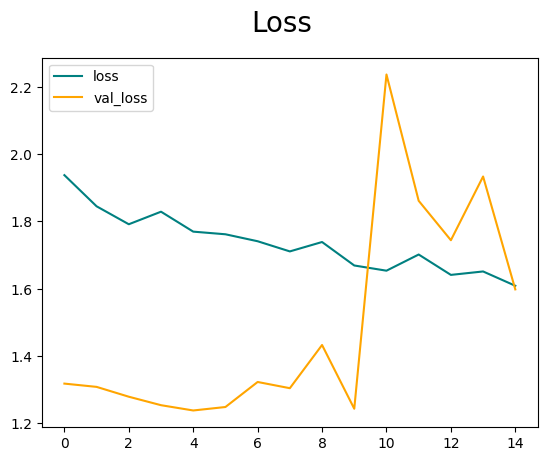

In [1555]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()



Now I will be plotting the training and validation accuracy

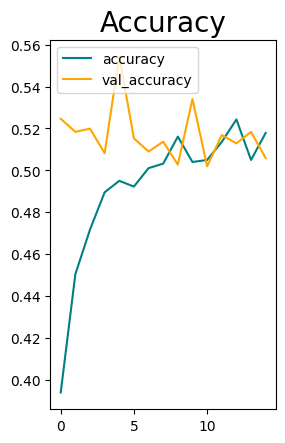

In [1556]:
# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()



Now that I have ran the model and analyzed the accuracy + loss, it is time to evaluate on the test data set

In [1557]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Ensure you import necessary modules
import numpy as np
from tqdm import tqdm  # For a progress bar


In [1558]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy()

The first time I tried to test the module, I woke up to find my testing had been running for 596 minutes (nearly 10 hours); therefore, I needed to implement a stopped in the for loop to be the length of the test_generator.

In [1559]:
# Number of steps in the validation generator
num_batches = len(combined_val_data)


After trying the num_batches method, I have learned that the only way to stop the for loop is to manually add a break function

In [1560]:
# Iterate over the test data generator with a counter
for i, batch in enumerate(combined_val_data):
    if i >= num_batches:
        break
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms

In [1561]:
# Get the results
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()

print(f'Precision: {precision_result}')
print(f'Recall: {recall_result}')
print(f'Accuracy: {accuracy_result}')

Precision: 0.8054474592208862
Recall: 0.16184519231319427
Accuracy: 0.5613760948181152


I have researched a way to save the weights from the trained model and change the dropout to avoid overfitting.

In [1426]:
# Save the entire model
model.save('model_checkpoint.h5')

# Load the model
from tensorflow.keras.models import load_model
model = load_model('model_checkpoint.h5')


In [ ]:
# Create a new model with updated dropout rates
new_model = Sequential()

In [ ]:
# Update the dropout rates as desired
new_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(208, 176, 3)))
new_model.add(BatchNormalization())
new_model.add(MaxPooling2D())
new_model.add(Dropout(0.3))  # Updated dropout rate

new_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(BatchNormalization())
new_model.add(MaxPooling2D())
new_model.add(Dropout(0.3))  # Updated dropout rate

new_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(BatchNormalization())
new_model.add(MaxPooling2D())
new_model.add(Dropout(0.3))  # Updated dropout rate

new_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(BatchNormalization())
new_model.add(MaxPooling2D())
new_model.add(Dropout(0.3))  # Updated dropout rate

new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(Dropout(0.5))
new_model.add(Dense(4, activation='softmax'))

In [ ]:
# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the weights from the previous model
new_model.set_weights(model.get_weights())

Now I will conduct tests from individual photos to guarantee the accuracy of my model

In [660]:
import cv2
import numpy as np

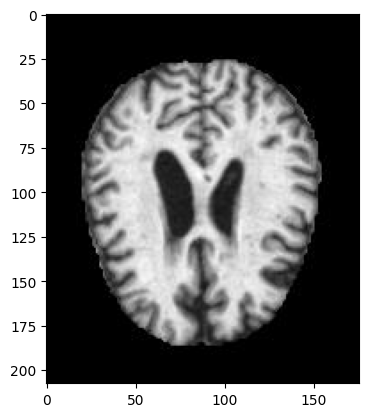

In [661]:
img = cv2.imread('/Users/gabeprice/Desktop/Blackwell Research 2024/Alzheimers Research/Alzheimer_s Photos/test/ModerateDemented/29.jpg')
plt.imshow(img)
plt.show()

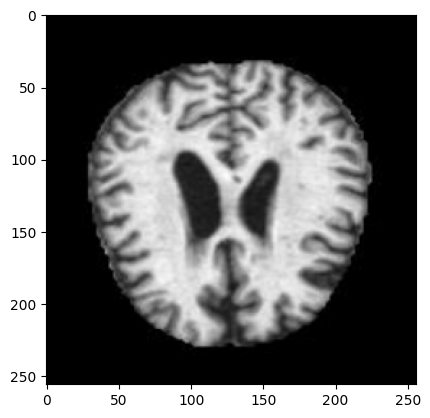

In [662]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [663]:
resize.shape

TensorShape([256, 256, 3])

In [664]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [665]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

2024-07-19 22:29:59.249122: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-07-19 22:29:59.249163: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_39_1/flatten_39_1/Reshape}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_39_1/flatten_39_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/gabeprice/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/85/89txm54n5njfp03xfr8f0qm40000gn/T/ipykernel_20353/1479965249.py", line 1, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py", line 175, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py", line 556, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4440, in reshape

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_39_1/flatten_39_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_20242245]

When I come back, I will learn how to analyze the y-hat value for my catgorical classes. In addition, I will begin to save the model as an h5.